In [0]:
print('hello')

hello


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
 

train_downloaded =drive.CreateFile({'id':'1HV9Wqtx4axR_9JnyiKTXbGS0mLrbPI7g'})
train_downloaded.GetContentFile('train.csv')
test_downloaded =drive.CreateFile({'id':'1lewxCJz9aYnOfHGQPeo65tzVpQfQ-wQ8'})
test_downloaded.GetContentFile('test.csv')


In [0]:
#data dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =[16,10]
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score






%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False


In [36]:
df_train = pd.read_csv('train.csv')
df_test =pd.read_csv("test.csv")
df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [0]:
df_test =pd.read_csv('test.csv')
df_test.head()

In [0]:
features = df_train[[	'vendor_id',			'passenger_count',	'pickup_longitude'	,'pickup_latitude'	,'dropoff_longitude'	,'dropoff_latitude']]


In [0]:
target=df_train['trip_duration']

In [0]:
tfeatures=df_test[['vendor_id'		,'passenger_count'	,'pickup_longitude'	,'pickup_latitude'	,'dropoff_longitude'	,'dropoff_latitude'	]]

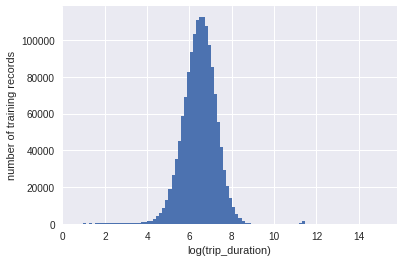

In [0]:
#data preprocessing

## how long is avg trip duration

df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values + 1)
plt.hist(df_train['log_trip_duration'].values, bins =100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of training records')
plt.show()

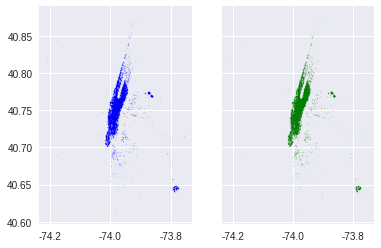

In [0]:
N=10000
city_long_border=(-74,-74)
city_lat_border=(40,40)
fig,ax = plt.subplots(ncols=2,sharex =True,sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N],
              df_train['pickup_latitude'].values[:N],
             color='blue',s=1,label='train',alpha=0.1)

ax[1].scatter(df_train['pickup_longitude'].values[:N],
              df_train['pickup_latitude'].values[:N],
             color='green',s=1,label='train',alpha=0.1)
plt.show()

In [0]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

In [0]:
params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 1, 
             'max_depth': 7, 'min_child_weight': 1,'learning_rate': 0.1, 'subsample': 0.8}

In [54]:
reg = xgb.XGBRegressor(n_estimators=100, seed=0,learning_rate=0.1, subsample=0.8,
                           colsample_bytree=1, max_depth=7,min_child_weight= 1)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

Number predicted less than 0: (4,)
Number predicted less than 0: (15,)
Number predicted less than 0: (20,)
Number predicted less than 0: (8,)
[0.65412313 0.65885624 0.65611558 0.64966921]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8)

In [56]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)
pred[pred < 0] = 0
df_test['trip_duration']=pred.astype(int)
out = df_test[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost2.csv',index=False)
#0.45743


(33,)
